# DL_HW3

In [21]:
import numpy as np
import pandas as pd
import os, cv2, time
from imageio import imread, imwrite
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
# from .autonotebook import tqdm as notebook_tqdm
import multiprocessing
from multiprocessing import Pool

# import torch
# import torch.nn as nn
# import torch.utils.data as Data
# import torchvision
# from torch.utils.data import DataLoader, TensorDataset
# from torchvision import datasets, transforms
# import torch.nn.functional as F



In [22]:
cpus = multiprocessing.cpu_count()
print(cpus)
# print(torch.cuda.is_available()) 

160


## Read Data

In [23]:
# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

In [24]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = np.array(pd.read_table('train.txt', header = None, sep = ' '))
val_idx = np.array(pd.read_table('val.txt', header = None, sep = ' '))
test_idx = np.array(pd.read_table('test.txt', header = None, delimiter = ' '))
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
train_onehot_y = self_onehot(train_y)
val_onehot_y = self_onehot(val_y)
test_onehot_y = self_onehot(test_y)
with Pool(processes = 80) as p:
    train_pic = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
    val_pic = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
    test_pic = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
    
train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

os.chdir('/home/rita/111/111-2DL/HW3')

100%|██████████| 450/450 [00:00<00:00, 1267.41it/s]


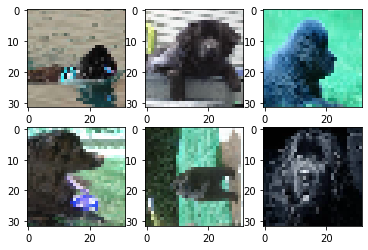

In [25]:
# print img
plt.subplot(2, 3, 1)
img = Image.fromarray(train_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 2)
img = Image.fromarray(val_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 3)
img = Image.fromarray(test_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 4)
img = Image.fromarray(train_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 5)
img = Image.fromarray(val_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 6)
img = Image.fromarray(test_pic[1].astype(np.uint8))
plt.imshow(img)

## Tensorflow Lenet5

In [54]:
# https://medium.com/@redmilk/tensorflow-%E7%AD%86%E8%A8%98-5-convolution-netowrk-%E5%AF%A6%E4%BD%9C-lenet-5%E6%A8%A1%E5%9E%8B-e23d95c9265f
# TF1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def load_data(num_classes=10):
    (xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()
    xtrain = xtrain.reshape(-1, 28, 28, 1).astype('float32') / 255
    xtest = xtest.reshape(-1, 28, 28, 1).astype('float32') / 255
    ytrain = np.eye(num_classes)[ytrain] # one hot encoding
    ytest = np.eye(num_classes)[ytest]   # one hot encoding
    return xtrain, ytrain, xtest, ytest

def next_batch(batch_size, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

xtrain, ytrain, xtest, ytest = load_data()
tf.reset_default_graph()
# Parameters
num_epoch = 4000
batch_size = 128

# layer 0: input data
x = tf.placeholder("float", [None,28,28,1])
y = tf.placeholder("float", [None,10])

# layer 1: convolution
# filter size = 5x5, input channel = 1, output channel = 32
conv1_w = tf.get_variable("conv1_w", [5,5,1,32], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1_b = tf.get_variable("conv1_b", [32], initializer=tf.constant_initializer(value=0))
conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='SAME')
relu1 = tf.nn.relu( tf.nn.bias_add(conv1, conv1_b) )

# layer 2: max pool
# filter size = 2x2, stride = 2
pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# layer 3: convolution
# filter size = 5x5, input channel = 32, output channel = 64
conv2_w = tf.get_variable("conv2_w", [5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2_b = tf.get_variable("conv2_b", [64], initializer=tf.constant_initializer(value=0))
conv2 = tf.nn.conv2d(pool1, conv2_w, strides=[1,1,1,1], padding='SAME')
relu2 = tf.nn.relu( tf.nn.bias_add(conv2, conv2_b) )

# layer 4: max pool
pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# layer 5: fully connected
fc1_w = tf.get_variable("fc1_w", [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc1_b = tf.get_variable("fc1_b", [1024], initializer=tf.constant_initializer(value=0.1))
pool2_vector = tf.reshape(pool2, [-1, 7 * 7 * 64])
fc1 = tf.nn.relu( tf.matmul(pool2_vector, fc1_w) + fc1_b )

# dropout layer
fc1_dropout = tf.nn.dropout(fc1, 1.0)

# layer 6: fully connected
fc2_w = tf.get_variable("fc2_w", [1024, 10], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc2_b = tf.get_variable("fc2_b", [10], initializer=tf.constant_initializer(value=0.1))
y_hat = tf.matmul(fc1_dropout, fc2_w) + fc2_b

# layer 7: softmax, output layer
pred = tf.nn.softmax(y_hat)

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_hat, labels=y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# evaluate model
correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

num_epoch = 400

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        xbatch, ybatch = next_batch(batch_size, xtrain, ytrain)
        sess.run(train_op, feed_dict={x: xbatch, y: ybatch})

        if ((epoch + 1) % 100 == 0):
            loss, acc = sess.run([loss_op, accuracy], feed_dict={x: xtest, y: ytest})
            print("epoch " + str(epoch+1) + ", loss= " + "{:.4f}".format(loss) + ", acc= " + "{:.3f}".format(acc))

    # Calculate accuracy for MNIST test images
    acc = sess.run(accuracy, feed_dict={x: xtest, y: ytest})
    print('test acc=' + '{:.3f}'.format(acc))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2023-05-13 23:38:17.015025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 57945 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:5b:00.0, compute capability: 8.0
2023-05-13 23:38:17.023649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 100, loss= 0.1191, acc= 0.962
epoch 200, loss= 0.0596, acc= 0.981
epoch 300, loss= 0.0486, acc= 0.984
epoch 400, loss= 0.0550, acc= 0.981
test acc=0.981


In [70]:
# test for own data
# https://medium.com/@redmilk/tensorflow-%E7%AD%86%E8%A8%98-5-convolution-netowrk-%E5%AF%A6%E4%BD%9C-lenet-5%E6%A8%A1%E5%9E%8B-e23d95c9265f
# TF1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



def next_batch(batch_size, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# xtrain, ytrain, xtest, ytest = load_data()
xtrain, ytrain, xtest, ytest = train_pic.astype(np.float32), train_onehot_y, test_pic.astype(np.float32), test_onehot_y
tf.reset_default_graph()
# Parameters
num_epoch = 400
batch_size = 128

# layer 0: input data
x = tf.placeholder("float", [None, 32, 32, 3])
# x = tf.placeholder("float", [None,28,28,1])
y = tf.placeholder("float", [None, 50])

# layer 1: convolution
# filter size = 5x5, input channel = 1, output channel = 32
# 32*32*3 -> 28*28*6
conv1_w = tf.get_variable("conv1_w", [5,5,3,6], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1_b = tf.get_variable("conv1_b", [6], initializer=tf.constant_initializer(value=0))
conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='SAME')
relu1 = tf.nn.relu( tf.nn.bias_add(conv1, conv1_b) )

# layer 2: max pool
# filter size = 2x2, stride = 2
# pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
# 28*28*6 -> 14*14*6
pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,1, 1,1], padding='SAME')

# layer 3: convolution
# filter size = 5x5, input channel = 32, output channel = 64
# 14*14*6 -> 10*10*16
conv2_w = tf.get_variable("conv2_w", [5,5,6,16], initializer=tf.truncated_normal_initializer(stddev=0.1))
conv2_b = tf.get_variable("conv2_b", [16], initializer=tf.constant_initializer(value=0))
conv2 = tf.nn.conv2d(pool1, conv2_w, strides=[1,1,1,1], padding='SAME')
relu2 = tf.nn.relu( tf.nn.bias_add(conv2, conv2_b) )

# layer 4: max pool
# pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
# 10*10*16 -> 5*5*16
pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,1, 1,1], padding='SAME')

# layer 5: fully connected
# fc1_w = tf.get_variable("fc1_w", [7 * 7 * 16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
# fc1_b = tf.get_variable("fc1_b", [120], initializer=tf.constant_initializer(value=0.1))
# pool2_vector = tf.reshape(pool2, [-1, 7 * 7 * 16])
# fc1 = tf.nn.relu( tf.matmul(pool2_vector, fc1_w) + fc1_b )

fc1_w = tf.get_variable("fc1_w", [5 * 5 * 16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc1_b = tf.get_variable("fc1_b", [120], initializer=tf.constant_initializer(value=0.1))
pool2_vector = tf.reshape(pool2, [-1, 5 * 5 * 16])
fc1 = tf.nn.relu( tf.matmul(pool2_vector, fc1_w) + fc1_b )

# dropout layer
fc1_dropout = tf.nn.dropout(fc1, 1.0)

# layer 6: fully connected
fc2_w = tf.get_variable("fc2_w", [120, 84], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc2_b = tf.get_variable("fc2_b", [84], initializer=tf.constant_initializer(value=0.1))
fc2 = tf.nn.relu( tf.matmul(fc1_dropout, fc2_w) + fc2_b )

# dropout layer
fc2_dropout = tf.nn.dropout(fc2, 1.0)

# layer 7: softmax, output layer
fc3_w = tf.get_variable("fc3_w", [84, 50], initializer=tf.truncated_normal_initializer(stddev=0.1))
fc3_b = tf.get_variable("fc3_b", [50], initializer=tf.constant_initializer(value=0.1))
y_hat = tf.matmul(fc2_dropout, fc3_w) + fc3_b
pred = tf.nn.softmax(y_hat)

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_hat, labels=y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# evaluate model
correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

num_epoch = 400

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        xbatch, ybatch = next_batch(batch_size, xtrain, ytrain)
        sess.run(train_op, feed_dict={x: xbatch, y: ybatch})

        if ((epoch + 1) % 100 == 0):
            loss, acc = sess.run([loss_op, accuracy], feed_dict={x: xtest, y: ytest})
            print("epoch " + str(epoch+1) + ", loss= " + "{:.4f}".format(loss) + ", acc= " + "{:.3f}".format(acc))

    # Calculate accuracy for MNIST test images
    acc = sess.run(accuracy, feed_dict={x: xtest, y: ytest})
    print('test acc=' + '{:.3f}'.format(acc))

2023-05-14 00:11:38.584389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 57945 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:5b:00.0, compute capability: 8.0


InvalidArgumentError: Graph execution error:

Detected at node 'Reshape' defined at (most recent call last):
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1235377/2052512882.py", line 59, in <module>
      pool2_vector = tf.reshape(pool2, [-1, 7 * 7 * 16])
Node: 'Reshape'
Input to reshape is a tensor with 131072 values, but the requested shape requires a multiple of 784
	 [[{{node Reshape}}]]

Original stack trace for 'Reshape':
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
    result = self._run_cell(
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1235377/2052512882.py", line 59, in <module>
    pool2_vector = tf.reshape(pool2, [-1, 7 * 7 * 16])
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py", line 199, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8551, in reshape
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3798, in _create_op_internal
    ret = Operation(


In [66]:
xtrain, ytrain, xtest, ytest = load_data()
print(xtrain.shape)
print(xtrain.dtype)
print(ytrain.shape)
print(ytrain.dtype)
print(train_pic.shape)
print(train_pic.dtype)
print(train_y.shape)
print(train_y.dtype)
print(train_onehot_y.shape)
print(train_onehot_y.dtype)

(60000, 28, 28, 1)
float32
(60000, 10)
float64
(63325, 32, 32, 3)
uint8
(63325,)
float64
(63325, 50)
float64


## Tensorflow2.0 Lenet5

In [71]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


## Tensorflow.Keras Lenet5

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
# import tensorflow.compat.v1 as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.2


In [27]:
# test on 50 figure
# https://zhuanlan.zhihu.com/p/134149111

# tf.enable_eager_execution()
def preprocess(x, y):
    # tf.cast : Casts a tensor to a new type.
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 32, 32, 3])
    y = tf.one_hot(y, depth=50)  # one_hot 编码
    return x, y

batch_size = 32
# 加载数据集
x_train, y_train, x_test, y_test = train_pic.astype(np.uint8), train_y.astype(np.uint8),  test_pic.astype(np.uint8), test_y.astype(np.uint8)
x_val, y_val = val_pic.astype(np.uint8), val_y.astype(np.uint8)

train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(10000)  # 打乱训练集样本
train_db = train_db.batch(batch_size)
train_db = train_db.map(preprocess)

val_db = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_db = val_db.shuffle(10000)  # 打乱训练集样本
val_db = val_db.batch(batch_size)
val_db = val_db.map(preprocess)

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(10000)  # 打乱测试集样本
test_db = test_db.batch(batch_size)
test_db = test_db.map(preprocess)

In [28]:
# 创建模型
model = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(6, 5),  # 使用6个5*5的卷积核对单通道32*32的图片进行卷积，结果得到6个28*28的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对28*28的特征图进行2*2最大池化，得到14*14的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层2
    keras.layers.Conv2D(16, 5),  # 使用16个5*5的卷积核对6通道14*14的图片进行卷积，结果得到16个10*10的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对10*10的特征图进行2*2最大池化，得到5*5的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层3
    keras.layers.Conv2D(120, 5),  # 使用120个5*5的卷积核对16通道5*5的图片进行卷积，结果得到120个1*1的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 将 (None, 1, 1, 120) 的下采样图片拉伸成 (None, 120) 的形状
    keras.layers.Flatten(),
    # 全连接层1
    keras.layers.Dense(84, activation='relu'),  # 120*84
    # 全连接层2
    keras.layers.Dense(50, activation='softmax')  # 84*10
])
model.build(input_shape=(None, 32, 32, 3))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
re_lu_4 (ReLU)               (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)        

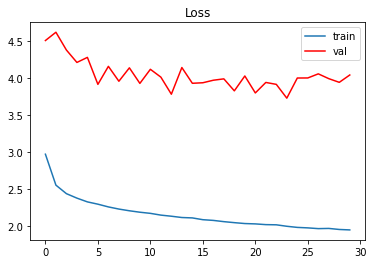

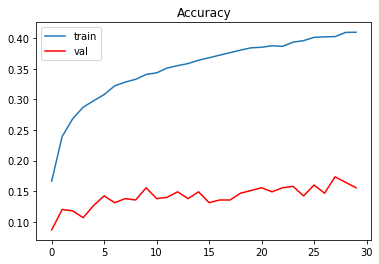

In [29]:
# %load_ext line_profiler

# @profile(precision=4, stream=open('./memory/memory_profiler_keras.log','w+'))
batch_size = 32
# def train_lenet(model):
#     model.build(input_shape=(batch_size, 32, 32, 3))
#     model.summary()

#     # model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#     model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#     # 训练
#     history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)
#     return model, history


# %lprun -f train_lenet train_lenet(model)
# model, history = train_lenet(model)

model.build(input_shape=(batch_size, 32, 32, 3))
model.summary()

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# 训练
history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)

model.save('./model/keras_Lenet5')

# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val", c = 'red')
plt.legend()
plt.savefig('./figure/keras_cnn_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val", c = 'red')
plt.legend()
plt.savefig('./figure/keras_cnn_acc.png')
plt.show()


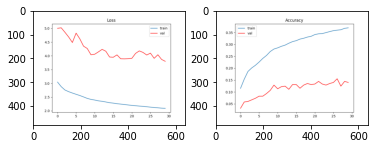

In [12]:
plt.subplot(1, 2, 1)
img = imread('./figure/keras_cnn_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./figure/keras_cnn_acc.png')
plt.imshow(img)

### Compare

In [13]:
import timeit, time
# https://pypi.org/project/keras-flops/
from keras_flops import get_flops


In [14]:
@tf.function
def model_static(x, y):
    y_pred = model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss
def model_dynamic(x, y):
    y_pred = model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss

print('static graph :', timeit.timeit(lambda: model_static(x_test, test_onehot_y), number = 10))
print('dynamic graph :', timeit.timeit(lambda: model_dynamic(x_test, test_onehot_y), number = 10))

static graph : 0.19461287558078766
dynamic graph : 0.05531592946499586


In [18]:
# https://pypi.org/project/keras-flops/

# loaded_model = keras.models.load_model('./model/keras_Lenet5')
# loaded_model.summary()

# inference time
time_start = time.perf_counter()
loss, acc = model.evaluate(test_db)
print("Time for Keras Lenet : {} s".format(time.perf_counter() - time_start))

# Accuracy
print('Accuracy for Keras Lenet : ', acc)
print('Loss for Keras Lenet : ', loss)

# space complexity
# https://pypi.org/project/model-profiler/
from model_profiler import model_profiler
Batch_size = 32

profile = model_profiler(model, Batch_size, use_units = ['GPU IDs', 'MFLOPs', 'GB', 'Million', 'MB'])
# profile = model_profiler(model, Batch_size)

print(profile)

# Flops
flops = get_flops(model, batch_size=32)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

15/15 [==============================] - 0s 3ms/step - loss: 3.7832 - accuracy: 0.1689
Time for Keras Lenet : 0.12481553666293621 s
Accuracy for Keras Lenet :  0.1688888818025589
Loss for Keras Lenet :  3.7832014560699463
| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0131  | MFLOPs  |
| GPU Memory Requirement           | 0.0012  | GB      |
| Model Parameters                 | 0.0654  | Million |
| Memory Required by Model Weights | 0.2495  | MB      |
Consider rewriting this model with the Functional API.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.0423 G


In [28]:
@profile(precision=4, stream=open('./memory/memory_profiler_keras.log','w+'))

def train_lenet(model):
    model.build(input_shape=(batch_size, 32, 32, 3))
    model.summary()

    # model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    # 训练
    history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)
    return model, history

model, history = train_lenet(model)

ERROR: Could not find file /tmp/ipykernel_1281929/2019920501.py
